In [1]:
!pip install wordcloud

In [2]:
import os
import warnings
import string
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from wordcloud import WordCloud
import spacy

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

warnings.filterwarnings("ignore")

In [3]:
%cd "/content/drive/MyDrive/大專生計畫"

/content/drive/MyDrive/大專生計畫


In [4]:
hurt_df = pd.read_csv("hurtlex_EN.tsv", sep="\t")
hurt_df.head()

,id,pos,category,stereotype,lemma,level
0,EN1382,n,qas,no,gag reel,inclusive
1,EN7077,a,cds,no,snotty,conservative
2,EN6856,n,is,yes,mendicant,conservative
3,EN5485,n,re,no,maffias,conservative
4,EN5024,n,cds,no,lying in trade,conservative


In [5]:
hurt_df["category"].unique()

array(['qas', 'cds', 'is', 're', 'om', 'an', 'or', 'svp', 'asm', 'pr',
       'dmc', 'asf', 'ddp', 'ps', 'pa', 'rci', 'ddf'], dtype=object)

In [6]:
hurt_df[hurt_df["category"] == "ps"]

,id,pos,category,stereotype,lemma,level
87,EN1895,n,ps,yes,changeling,conservative
121,EN2772,n,ps,yes,interfertility,inclusive
131,EN2985,n,ps,yes,lummox,conservative
165,EN6078,n,ps,yes,nigga,conservative
176,EN2737,n,ps,yes,cross-breed,inclusive
...,...,...,...,...,...,...
8065,EN4545,n,ps,yes,jewity,inclusive
8092,EN6125,n,ps,yes,blk ppl,inclusive
8203,EN2759,n,ps,yes,interfertile,inclusive
8206,EN6084,n,ps,yes,the n-word,conservative


In [7]:
train_df = pd.read_json(os.path.join("data", "train.jsonl"), lines=True)
train_df.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [8]:
nlp = spacy.load("en_core_web_sm")

def remove_and_lemma(text):
    text = text.lower()
    return [token.lemma_ for token in nlp(text) if not token.is_stop and token.is_alpha]

train_df["tokens"] = train_df["text"].apply(remove_and_lemma)
train_df.head()

,id,img,label,text,tokens
0,42953,img/42953.png,0,its their character not their color that matters,"[character, color, matter]"
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...,"[afraid, love, like, ex]"
2,13894,img/13894.png,0,putting bows on your pet,"[put, bow, pet]"
3,37408,img/37408.png,0,i love everything and everybody! except for sq...,"[love, everybody, squirrel, hate, squirrel]"
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h...","[everybody, love, chocolate, chip, cookie, hit..."


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

def draw_wordcloud(series):
    corpus = [" ".join(tokens) for tokens in series]
    # construct the corpus
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names_out()
    tfidf_values = X.todense().tolist()
    df = pd.DataFrame(tfidf_values, columns=feature_names)

    wc = WordCloud(
        background_color="white",
        max_words=2000,
        max_font_size=60,
    )
    # create wordcloud
    wc.generate_from_frequencies(df.T.sum(axis=1))

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

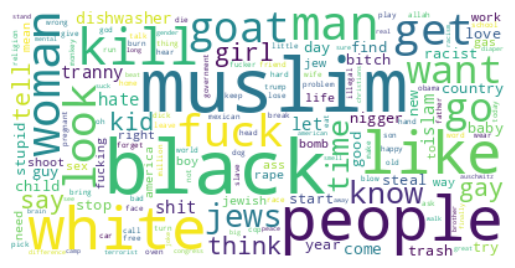

In [19]:
draw_wordcloud(train_df[train_df["label"]==1]["tokens"])

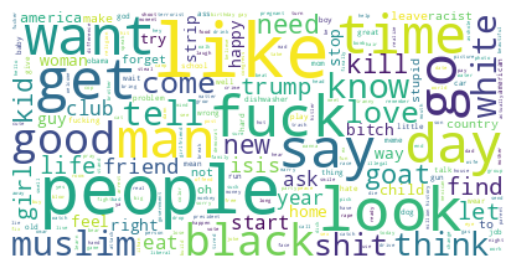

In [20]:
draw_wordcloud(train_df[train_df["label"]==0]["tokens"])

In [ ]:
df = pd.read_json(os.path.join("data", "processed_train.jsonl"), lines=True)
df.head()

,id,img,label,text,caption
0,42953,img/42953.png,0,its their character not their color that matters,a man with a bald head and a bald face
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...,a man and woman kissing in front of a lake
2,13894,img/13894.png,0,putting bows on your pet,a cat with a red bow on its neck
3,37408,img/37408.png,0,i love everything and everybody! except for sq...,"a dog with a capt that says, exitouris ha sures"
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h...",a man in a suit and tie is standing in front o...


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

def sentence_embed(row):
    sentences = [row["text"], row["caption"]]
    sentences = sentences + [" [SEP] ".join(sentences)]
    # Tokenize sentences
    encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)

    # Perform pooling
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    # Normalize embeddings
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
    return sentence_embeddings

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

In [ ]:
tc_sim = []
tc_vs_tc_sim = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    embeddings = sentence_embed(row)
    tc_sim.append(
        (embeddings[0]@embeddings[1].T).item()
    )
    tc_vs_tc_sim.append(
        (((embeddings[0]+embeddings[1])/2)@embeddings[2].T).item()
    )

  0%|          | 0/8500 [00:00<?, ?it/s]

In [ ]:
df["text_and_capion_sim"] = tc_sim
df["text_add_capion_sim"] = tc_vs_tc_sim
df.head()

,id,img,label,text,caption,text_and_capion_sim,text_add_capion_sim
0,42953,img/42953.png,0,its their character not their color that matters,a man with a bald head and a bald face,0.088631,0.690084
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...,a man and woman kissing in front of a lake,0.154198,0.695448
2,13894,img/13894.png,0,putting bows on your pet,a cat with a red bow on its neck,0.530128,0.842910
3,37408,img/37408.png,0,i love everything and everybody! except for sq...,"a dog with a capt that says, exitouris ha sures",0.144956,0.689145
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h...",a man in a suit and tie is standing in front o...,-0.060426,0.623367


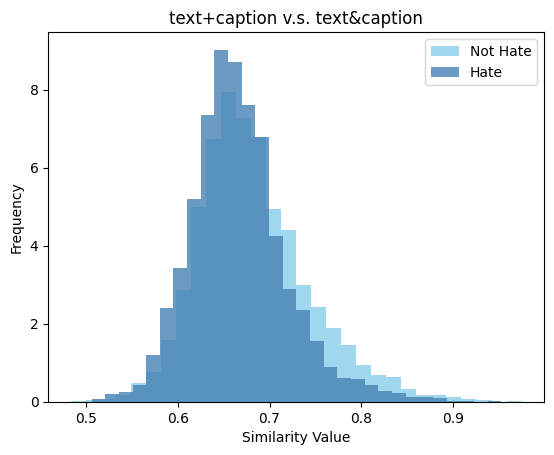

In [ ]:
plt.hist(df[df["label"]==0]['text_add_capion_sim'], bins=30, color='skyblue', alpha=0.8, label="Not Hate", density=True)
plt.hist(df[df["label"]==1]['text_add_capion_sim'], bins=30, color='steelblue', alpha=0.8, label="Hate", density=True)

plt.title('text+caption v.s. text&caption')
plt.xlabel('Similarity Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

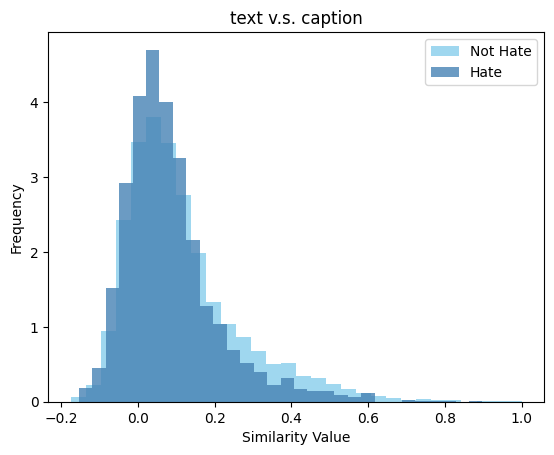

In [ ]:
plt.hist(df[df["label"]==0]['text_and_capion_sim'], bins=30, color='skyblue', alpha=0.8, label="Not Hate", density=True)
plt.hist(df[df["label"]==1]['text_and_capion_sim'], bins=30, color='steelblue', alpha=0.8, label="Hate", density=True)

plt.title('text v.s. caption')
plt.xlabel('Similarity Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

In [ ]:
hurt_df = pd.read_csv("hurtlex_EN.tsv", sep="\t")
hurt_df.head()

,id,pos,category,stereotype,lemma,level
0,EN1382,n,qas,no,gag reel,inclusive
1,EN7077,a,cds,no,snotty,conservative
2,EN6856,n,is,yes,mendicant,conservative
3,EN5485,n,re,no,maffias,conservative
4,EN5024,n,cds,no,lying in trade,conservative


In [ ]:
hurt_vocabs = set(hurt_df["lemma"])
def contain_hurt(tokens):
    cnt = 0
    for token in set(tokens):
        if token in hurt_vocabs:
            cnt += 1
    return cnt

train_df["hurt"] = train_df["tokens"].apply(contain_hurt)
train_df.head()

,id,img,label,text,tokens,hurt
0,42953,img/42953.png,0,its their character not their color that matters,"[character, color, matters]",0
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...,"[afraid, love, everyone, like, ex]",1
2,13894,img/13894.png,0,putting bows on your pet,"[putting, bows, pet]",0
3,37408,img/37408.png,0,i love everything and everybody! except for sq...,"[love, everything, everybody, except, squirrel...",1
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h...","[everybody, loves, chocolate, chip, cookies, e...",0


In [ ]:
dev_df = pd.read_json(os.path.join("data", "dev.jsonl"), lines=True)
dev_df.head()

,id,img,label,text
0,8291,img/08291.png,1,white people is this a shooting range
1,46971,img/46971.png,1,bravery at its finest
2,3745,img/03745.png,1,your order comes to $37.50 and your white priv...
3,83745,img/83745.png,1,it is time.. to send these parasites back to t...
4,80243,img/80243.png,1,mississippi wind chime


In [ ]:
dev_df["tokens"] = dev_df["text"].apply(get_clean_tokens)
dev_df.head()

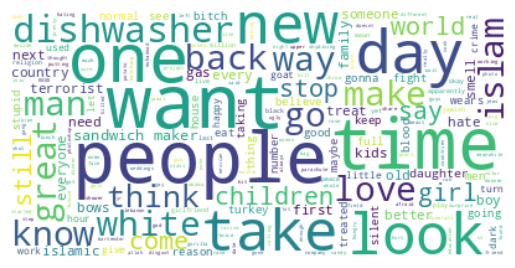

In [ ]:
draw_wordcloud(dev_df[dev_df["label"]==0]["tokens"])

In [ ]:
dev_df["hurt"] = dev_df["tokens"].apply(contain_hurt)
dev_df.head()

,id,img,label,text,tokens,hurt
0,8291,img/08291.png,1,white people is this a shooting range,"[white, people, shooting, range]",2
1,46971,img/46971.png,1,bravery at its finest,"[bravery, finest]",0
2,3745,img/03745.png,1,your order comes to $37.50 and your white priv...,"[order, comes, 37, 50, white, privilege, disco...",1
3,83745,img/83745.png,1,it is time.. to send these parasites back to t...,"[time, send, parasites, back, desert]",1
4,80243,img/80243.png,1,mississippi wind chime,"[mississippi, wind, chime]",0


In [ ]:
train_df[train_df["label"] == 0]["hurt"].value_counts()

0    2783
1    1805
2     662
3     162
4      30
5       8
Name: hurt, dtype: int64

In [ ]:
dev_df[dev_df["label"] == 1]["hurt"].value_counts()

0    115
1     86
2     39
3      5
4      4
5      1
Name: hurt, dtype: int64

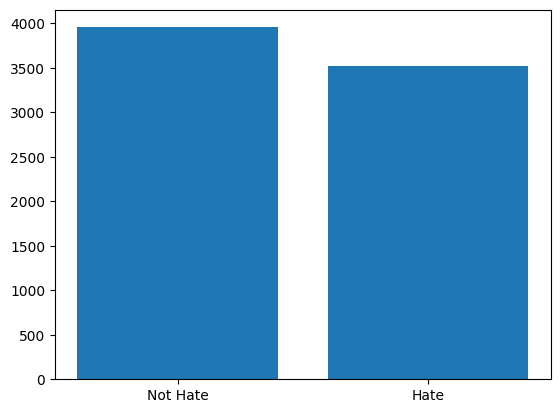

In [ ]:
plt.bar(
    ["Not Hate", "Hate"],
    [sum(train_df[train_df["label"] == 0]["hurt"]), sum(train_df[train_df["label"] == 1]["hurt"])]
)
plt.show()